In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator
from jupyter_utils import AllDataset
from gene_finding.pathway_matrix import load_pathway, get_valid_enrichr_pathways

import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
tf.random.set_seed(1)
from cxplain import CXPlain


data_dir = '../drp-data/'
GDSC_GENE_EXPRESSION = 'preprocessed/gdsc_tcga/gdsc_rma_gene_expr.csv'
TCGA_GENE_EXPRESSION = 'preprocessed/gdsc_tcga/tcga_log2_gene_expr.csv'
enrichr_pathway = 'pathways/9606.enrichr_pathway.edge'
enrichr_pathway_nodemap = 'pathways/9606.enrichr_pathway.node_map'

TCGA_TISSUE = 'preprocessed/tissue_type/TCGA_tissue_one_hot.csv'
GDSC_TISSUE = 'preprocessed/tissue_type/GDSC_tissue_one_hot.csv'

GDSC_lnIC50 = 'preprocessed/drug_response/gdsc_lnic50.csv'
TCGA_DR = 'preprocessed/drug_response/tcga_drug_response.csv'

print('reading dataset')
dataset = AllDataset(data_dir, GDSC_GENE_EXPRESSION, TCGA_GENE_EXPRESSION, 
                     GDSC_lnIC50, TCGA_DR, TCGA_TISSUE)

list_of_pathways = get_valid_enrichr_pathways(data_dir + enrichr_pathway_nodemap)
pathway_matrix, pathway_names = load_pathway(data_dir + enrichr_pathway, dataset.genes, list_of_pathways, 10, sort=True)

mx = pd.DataFrame(pathway_matrix, index=pathway_names, columns=dataset.hgnc)
path_size = mx.sum(axis=1)

drugs = [
#     'bleomycin',
    'cisplatin',]
#     'cyclophosphamide',
#     'docetaxel',
#     'doxorubicin',]
#     'etoposide',
#     'gemcitabine',
#     'irinotecan',
#     'oxaliplatin',
#     'paclitaxel',
#     'pemetrexed',
#     'tamoxifen',
#     'temozolomide',
#     'vinorelbine']  

root_dir = 'gene_finding/results/'

Instructions for updating:
non-resource variables are not supported in the long term
reading dataset
Number of Homo sapiens pathways: 490
Number of valid pathways: 439


In [2]:
def get_explainers(folder):
    exp_dict = {}
    for i, drug in enumerate(drugs):

        exp = CXPlain.load('gene_finding/results/%s/%s/explainer'%(folder, drug), custom_model_loader=None, relpath=True)
        exp_dict[drug] = exp
    return exp_dict

In [3]:
explainers = get_explainers('CX_ens_enrichr3_diff')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [4]:
def read_baselines(folder):
    bls = {}
    for drug in drugs:
        x = pd.read_csv(root_dir + folder + '/' + drug + '/baselines.csv', index_col=0)
        bls[drug] = x
        
    return bls

In [5]:
diff = read_baselines('CX_ens_enrichr3_diff')

In [6]:
drug='cisplatin'

In [7]:
gdsc_expr, gdsc_dr, _, test_tcga_expr = dataset.filter_and_normalize_data(drug)

In [8]:
attr_tcga,conf_tcga = explainers[drug].explain_groups(test_tcga_expr.values)
attr_tcga = pd.DataFrame(attr_tcga, index=test_tcga_expr.index, columns=pathway_names)
attr_gdsc,conf_gdsc = explainers[drug].explain_groups(gdsc_expr.values)
attr_gdsc = pd.DataFrame(attr_gdsc, index=gdsc_expr.index, columns=pathway_names)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [9]:
attr_tcga.mean(axis=0).sort_values(ascending=False)[:10]

WIKIPATH_CIRCADIAN_RYTHM_RELATED_GENES_HOMO_SAPIENS_WP3594         0.005694
WIKIPATH_FOCAL_ADHESION_HOMO_SAPIENS_WP306                         0.005413
WIKIPATH_GPCRS__CLASS_A_RHODOPSIN_LIKE_HOMO_SAPIENS_WP455          0.005218
WIKIPATH_MRNA_PROCESSING_HOMO_SAPIENS_WP411                        0.004582
WIKIPATH_CYTOPLASMIC_RIBOSOMAL_PROTEINS_HOMO_SAPIENS_WP477         0.004567
WIKIPATH_METAPATHWAY_BIOTRANSFORMATION_HOMO_SAPIENS_WP702          0.004501
WIKIPATH_NRF2_PATHWAY_HOMO_SAPIENS_WP2884                          0.004466
WIKIPATH_APOPTOSIS_MODULATION_AND_SIGNALING_HOMO_SAPIENS_WP1772    0.004291
WIKIPATH_PEPTIDE_GPCRS_HOMO_SAPIENS_WP24                           0.004190
WIKIPATH_REGULATION_OF_TOLL_LIKE_RECEPTOR_SIGNALING_PATHWAY_HOM    0.004074
dtype: float32

In [10]:
attr_gdsc.mean(axis=0).sort_values(ascending=False)[:10]

WIKIPATH_CIRCADIAN_RYTHM_RELATED_GENES_HOMO_SAPIENS_WP3594         0.019633
WIKIPATH_FOCAL_ADHESION_HOMO_SAPIENS_WP306                         0.013486
WIKIPATH_CYTOPLASMIC_RIBOSOMAL_PROTEINS_HOMO_SAPIENS_WP477         0.013424
WIKIPATH_GPCRS__CLASS_A_RHODOPSIN_LIKE_HOMO_SAPIENS_WP455          0.012889
WIKIPATH_METAPATHWAY_BIOTRANSFORMATION_HOMO_SAPIENS_WP702          0.012513
WIKIPATH_MRNA_PROCESSING_HOMO_SAPIENS_WP411                        0.010053
WIKIPATH_ECTODERM_DIFFERENTIATION_HOMO_SAPIENS_WP2858              0.009022
WIKIPATH_NEURAL_CREST_DIFFERENTIATION_HOMO_SAPIENS_WP2064          0.008406
WIKIPATH_REGULATION_OF_TOLL_LIKE_RECEPTOR_SIGNALING_PATHWAY_HOM    0.008031
WIKIPATH_NRF2_PATHWAY_HOMO_SAPIENS_WP2884                          0.007810
dtype: float32

In [11]:
set(attr_tcga.mean(axis=0).sort_values(ascending=False)[:6].index).intersection(set(attr_gdsc.mean(axis=0).sort_values(ascending=False)[:6].index))

{'WIKIPATH_CIRCADIAN_RYTHM_RELATED_GENES_HOMO_SAPIENS_WP3594',
 'WIKIPATH_CYTOPLASMIC_RIBOSOMAL_PROTEINS_HOMO_SAPIENS_WP477',
 'WIKIPATH_FOCAL_ADHESION_HOMO_SAPIENS_WP306',
 'WIKIPATH_GPCRS__CLASS_A_RHODOPSIN_LIKE_HOMO_SAPIENS_WP455',
 'WIKIPATH_METAPATHWAY_BIOTRANSFORMATION_HOMO_SAPIENS_WP702',
 'WIKIPATH_MRNA_PROCESSING_HOMO_SAPIENS_WP411'}

(array([  4.,   8.,  29.,  47.,  82., 103.,  86.,  42.,  15.,   6.,   4.,
          4.,   2.,   1.,   2.,   2.,   1.,   0.,   0.,   1.]),
 array([0.00079696, 0.00104064, 0.00128432, 0.00152799, 0.00177167,
        0.00201535, 0.00225903, 0.0025027 , 0.00274638, 0.00299006,
        0.00323374, 0.00347741, 0.00372109, 0.00396477, 0.00420845,
        0.00445212, 0.0046958 , 0.00493948, 0.00518316, 0.00542683,
        0.00567051], dtype=float32),
 <BarContainer object of 20 artists>)

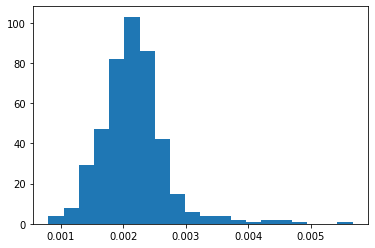

In [12]:
plt.hist(attr_tcga.iloc[0], bins=20)

(array([ 3.,  9., 12., 33., 77., 69., 80., 58., 35., 21., 19., 11.,  2.,
         3.,  2.,  1.,  2.,  1.,  0.,  1.]),
 array([0.00162486, 0.00172196, 0.00181906, 0.00191617, 0.00201327,
        0.00211037, 0.00220748, 0.00230458, 0.00240168, 0.00249878,
        0.00259589, 0.00269299, 0.00279009, 0.00288719, 0.0029843 ,
        0.0030814 , 0.0031785 , 0.0032756 , 0.00337271, 0.00346981,
        0.00356691], dtype=float32),
 <BarContainer object of 20 artists>)

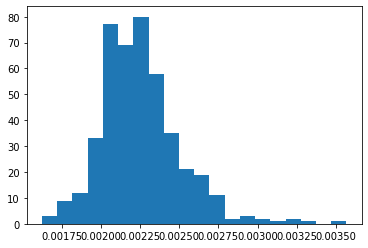

In [13]:
plt.hist(attr_gdsc.iloc[0], bins=20)

In [14]:
attr_gdsc['WIKIPATH_CIRCADIAN_RYTHM_RELATED_GENES_HOMO_SAPIENS_WP3594'].max()

0.9889659

In [15]:
attr_tcga['WIKIPATH_CIRCADIAN_RYTHM_RELATED_GENES_HOMO_SAPIENS_WP3594'].max()

0.031048324

(0.0, 100.0)

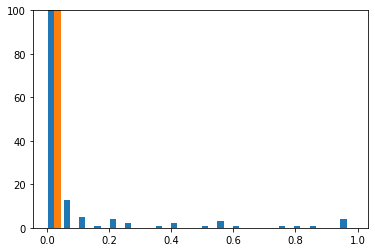

In [16]:
plt.hist([attr_gdsc['WIKIPATH_CIRCADIAN_RYTHM_RELATED_GENES_HOMO_SAPIENS_WP3594'],
          attr_tcga['WIKIPATH_CIRCADIAN_RYTHM_RELATED_GENES_HOMO_SAPIENS_WP3594']], bins=20)
plt.ylim(top=100)

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

top6 = rank_diff[drug].loc[range(6)]['mean'].values
for i in range(6):
    ax = axes[i%3][i//3]
    ax.hist(diff[drug][top6[i]], bins=20)
    ax.set_title(top6[i][:50])
    ax.axvline(diff[drug][top6[i]].mean(), color='r', label='mean')
    ax.axvline(diff[drug][top6[i]].median(), color='orange', label='median')
plt.show()

## Load the Prediction Model to find the omegas

In [17]:
from gene_finding.models import load_model, EnsModel
import torch
models = []

for i in range(1, 11):
    mod = load_model(seed=i,drug=drug,n_genes=len(dataset.genes))
    mod.eval()
    models.append(mod)
    
ens = EnsModel(models)

In [18]:
from gene_finding.precalculate_omega import precalculate_omegas
loss = torch.nn.MSELoss(reduction='none')
omegas,_ = precalculate_omegas(ens, gdsc_expr, gdsc_dr, pathway_matrix, loss, mode='none', return_sum_one=False)

cuda
(439, 15650)
torch.Size([945, 1])
model_loss torch.Size([945, 1])
100
200
300
400
500
600
700
800
900


In [20]:
omega_dist = pd.DataFrame(omegas/omegas.sum(axis=-1, keepdims=True), gdsc_expr.index, columns=pathway_names)

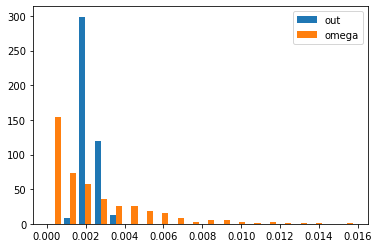

In [60]:
i = 200
plt.hist([attr_gdsc.iloc[i].values, omega_dist.iloc[i].values], label=['out', 'omega'], bins=20)
plt.legend()
plt.show()

In [30]:
attr_gdsc.iloc[1].sum()

0.7046497

In [58]:
exp = explainers['cisplatin']
k = [exp._predict_single(exp.prediction_model[0], np.asarray(gdsc_expr.iloc[1].values).reshape((1,-1))),
     exp._predict_single(exp.prediction_model[1], np.asarray(gdsc_expr.iloc[1].values).reshape((1,-1))),
     exp._predict_single(exp.prediction_model[2], np.asarray(gdsc_expr.iloc[1].values).reshape((1,-1)))]
k = np.concatenate(k)
np.median(k, axis=0).sum()

0.7046497

Text(0.5, 0, '$|P|$')

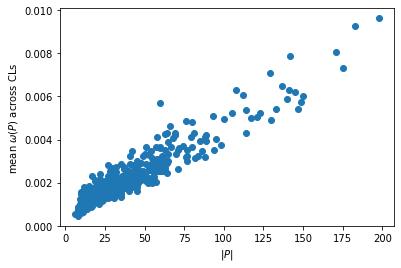

In [210]:
y = omega_dist.mean(axis=0)
plt.scatter(path_size[y.index], y.values)
plt.ylabel(r'mean $\omega(P)$ across CLs')
plt.xlabel(r'$|P|$')

In [221]:
path_size[omega_dist.columns].values.shape

(439,)

In [227]:
omegas/(path_size[omega_dist.columns].values)#.reshape(-1,1)

,WIKIPATH_METASTATIC_BRAIN_TUMOR_HOMO_SAPIENS_WP2249,WIKIPATH_TYPE_III_INTERFERON_SIGNALING_HOMO_SAPIENS_WP2113,NCI_SIGNALING_MEDIATED_BY_P38_GAMMA_AND_P38_DELTA_HOMO_SAPIENS_,WIKIPATH_IRINOTECAN_PATHWAY_HOMO_SAPIENS_WP229,WIKIPATH_NUCLEOTIDE_GPCRS_HOMO_SAPIENS_WP80,WIKIPATH_TFS_REGULATE_MIRNAS_RELATED_TO_CARDIAC_HYPERTROPHY_HOM,WIKIPATH_VITAMIN_D_METABOLISM_HOMO_SAPIENS_WP1531,WIKIPATH_STEROID_BIOSYNTHESIS_HOMO_SAPIENS_WP496,WIKIPATH_RALA_DOWNSTREAM_REGULATED_GENES_HOMO_SAPIENS_WP2290,WIKIPATH_HOMOLOGOUS_RECOMBINATION_HOMO_SAPIENS_WP186,...,WIKIPATH_INTEGRATED_BREAST_CANCER_PATHWAY_HOMO_SAPIENS_WP1984,WIKIPATH_METAPATHWAY_BIOTRANSFORMATION_HOMO_SAPIENS_WP702,WIKIPATH_MYOMETRIAL_RELAXATION_AND_CONTRACTION_PATHWAYS_HOMO_SA,WIKIPATH_INSULIN_SIGNALING_HOMO_SAPIENS_WP481,WIKIPATH_MAPK_SIGNALING_PATHWAY_HOMO_SAPIENS_WP382,WIKIPATH_EGF_EGFR_SIGNALING_PATHWAY_HOMO_SAPIENS_WP437,WIKIPATH_FOCAL_ADHESION_HOMO_SAPIENS_WP306,WIKIPATH_INTEGRATED_PANCREATIC_CANCER_PATHWAY_HOMO_SAPIENS_WP23,WIKIPATH_CIRCADIAN_RYTHM_RELATED_GENES_HOMO_SAPIENS_WP3594,WIKIPATH_GPCRS__CLASS_A_RHODOPSIN_LIKE_HOMO_SAPIENS_WP455
906826,5.642961e-06,2.098050e-05,1.635763e-05,6.673799e-06,1.250000e-08,1.891592e-05,1.111111e-08,3.726025e-05,1.111111e-08,4.413072e-07,...,5.550907e-06,3.756706e-06,1.564666e-05,4.827922e-06,1.948732e-05,1.055435e-05,5.847953e-10,1.320753e-05,6.508209e-06,8.415365e-06
687983,3.066349e-05,6.344215e-06,4.137069e-06,1.250000e-08,4.578855e-06,1.652045e-05,1.111111e-08,1.189179e-06,1.601423e-05,1.000000e-08,...,1.745501e-07,7.042254e-10,6.896552e-10,6.274287e-06,7.338814e-07,3.253275e-07,1.626797e-06,5.714286e-10,5.464481e-10,1.415461e-06
910927,1.910143e-05,1.428571e-08,1.250000e-08,9.537442e-06,1.250000e-08,1.250000e-08,4.406651e-05,1.111111e-08,1.319358e-05,3.402969e-05,...,7.092199e-10,2.475606e-06,1.096779e-05,6.802721e-10,6.835923e-07,7.294702e-06,3.603902e-06,6.577644e-06,3.734039e-06,4.388893e-06
1240138,1.666667e-08,1.428571e-08,1.250000e-08,9.927840e-06,1.250000e-08,1.250000e-08,2.830988e-06,5.783386e-05,6.427756e-06,1.000000e-08,...,7.092199e-10,7.042254e-10,2.343850e-07,6.802721e-10,6.711409e-10,6.666667e-10,5.847953e-10,5.714286e-10,5.464481e-10,1.481759e-06
1240139,1.666667e-08,1.043161e-06,2.127786e-08,7.073299e-08,1.250000e-08,3.844312e-06,1.111111e-08,2.200932e-06,1.111111e-08,1.000000e-08,...,8.780613e-07,1.491765e-06,2.543765e-08,6.802721e-10,6.711409e-10,6.603257e-08,8.072144e-07,1.032483e-06,1.924701e-07,5.050505e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908145,3.200211e-05,5.847907e-05,7.780059e-05,1.250000e-08,6.653694e-05,6.680121e-05,3.704160e-05,1.111111e-08,7.510289e-05,1.000000e-08,...,7.346986e-06,6.657620e-05,4.719952e-05,7.510730e-06,1.758715e-05,3.762282e-06,6.080551e-05,2.359726e-05,3.763045e-05,4.595525e-05
1298157,2.170411e-06,1.428571e-08,2.320693e-06,1.250000e-08,4.763965e-07,1.250000e-08,1.111111e-08,1.111111e-08,3.361278e-07,7.190902e-07,...,1.578209e-07,1.386545e-06,6.896552e-10,6.802721e-10,6.711409e-10,6.666667e-10,5.847953e-10,5.714286e-10,4.512718e-07,1.984764e-08
1480372,1.666667e-08,1.508069e-05,1.250000e-08,2.244322e-05,1.250000e-08,1.250000e-08,1.111111e-08,1.111111e-08,1.111111e-08,2.205633e-05,...,7.092199e-10,1.667062e-06,6.896552e-10,3.215502e-07,6.597321e-06,6.666667e-10,5.847953e-10,3.518229e-06,3.226514e-06,1.640722e-06
1298533,1.121576e-05,4.720808e-05,4.353933e-06,4.062057e-05,6.279326e-06,3.419293e-05,1.172525e-05,1.111111e-08,2.096956e-05,2.607182e-05,...,3.179113e-05,1.423549e-05,3.971384e-06,8.777481e-06,1.204527e-05,1.257246e-05,3.539085e-05,2.223940e-05,2.528975e-05,5.050505e-10


Text(0.5, 0, '$|P|$')

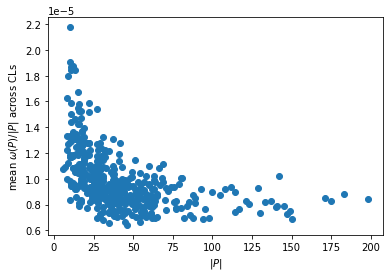

In [233]:
y = omegas/(path_size[omega_dist.columns].values)
plt.scatter(path_size[omegas.columns], y.mean(axis=0))
plt.ylabel(r'mean $\omega(P)/|P|$ across CLs')
plt.xlabel(r'$|P|$')

Text(0.5, 0, '$|P|$')

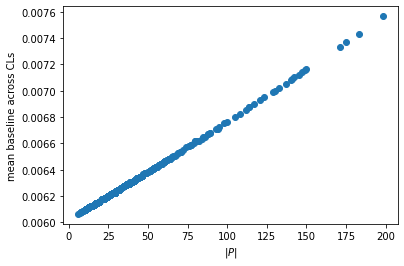

In [76]:
sorted_baseline = diff[drug].mean(axis=0).sort_values(ascending=False)
plt.scatter(path_size[sorted_baseline.index], sorted_baseline.values)
plt.ylabel(r'mean baseline across CLs')
plt.xlabel(r'$|P|$')

Text(0.5, 0, '$|P|$')

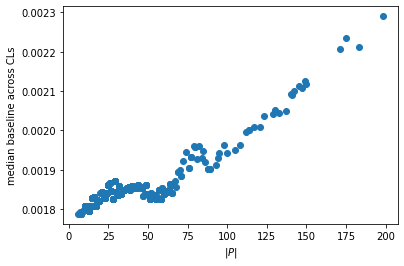

In [107]:
sorted_baseline = diff[drug].median(axis=0).sort_values(ascending=False)
plt.scatter(path_size[sorted_baseline.index], sorted_baseline.values)
plt.ylabel(r'median baseline across CLs')
plt.xlabel(r'$|P|$')

In [77]:
diff[drug].shape

(945, 439)

In [78]:
omegas.shape

(945, 439)

Text(0, 0.5, 'unnormalized omega')

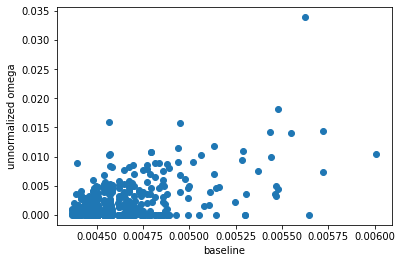

In [81]:
plt.scatter(diff[drug].iloc[0], omega_dist.iloc[0])
plt.xlabel('baseline')
plt.ylabel('unnormalized omega')

In [82]:
kl = torch.nn.KLDivLoss()

In [102]:
w = torch.FloatTensor(omega_dist.values)
a = torch.FloatTensor(attr_gdsc.values)
kl(a.log(), w)

tensor(0.0042)

In [86]:
k = [exp._predict_single(exp.prediction_model[0], np.asarray(gdsc_expr.values)),
     exp._predict_single(exp.prediction_model[1], np.asarray(gdsc_expr.values)),
     exp._predict_single(exp.prediction_model[2], np.asarray(gdsc_expr.values))]

In [103]:
a = torch.FloatTensor(k[0])
kl(a.log(), w)

tensor(0.0044)

In [104]:
a = torch.FloatTensor(k[1])
kl(a.log(),w)

tensor(0.0047)

In [105]:
a = torch.FloatTensor(k[2])
kl(a.log(), w)

tensor(0.0043)

In [118]:
omegas = pd.DataFrame(omegas, index=gdsc_expr.index, columns=pathway_names)

In [131]:
omegas.index = [int(x) for x in omegas.index]

In [208]:
diff_omega = np.maximum(omegas-diff[drug], np.ones(omegas.shape)*1e-7)
diff_omega = diff_omega/diff_omega.values.sum(axis=-1, keepdims=True)

Text(0.5, 0, '$|P|$')

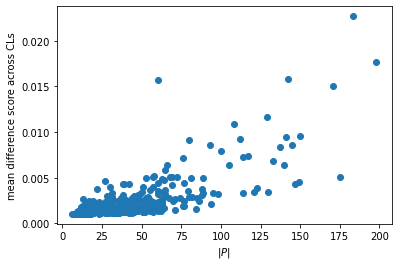

In [209]:
y = diff_omega.mean(axis=0).sort_values(ascending=False)
plt.scatter(path_size[y.index], y.values)
plt.ylabel(r'mean difference score across CLs')
plt.xlabel(r'$|P|$')

Text(0.5, 0, '$|P|$')

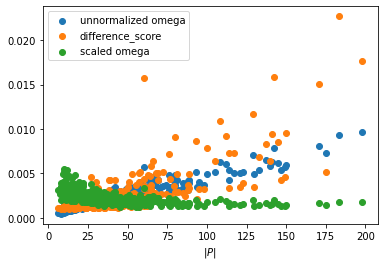

In [149]:
unnorm_omega = omega_dist.mean(axis=0)
scaled_omega = (omega_dist/path_size[omega_dist.columns]).mean(axis=0)
scaled_omega = scaled_omega/scaled_omega.values.sum(axis=-1, keepdims=True)
y = diff_omega.mean(axis=0)

plt.scatter(path_size[unnorm_omega.index], unnorm_omega.values, label='unnormalized omega')
plt.scatter(path_size[y.index], y.values, label='difference_score')
plt.scatter(path_size[scaled_omega.index], scaled_omega.values, label='scaled omega')
# plt.ylabel(r'mean difference score across CLs')
plt.legend()
plt.xlabel(r'$|P|$')

Text(0.5, 0, '$|P|$')

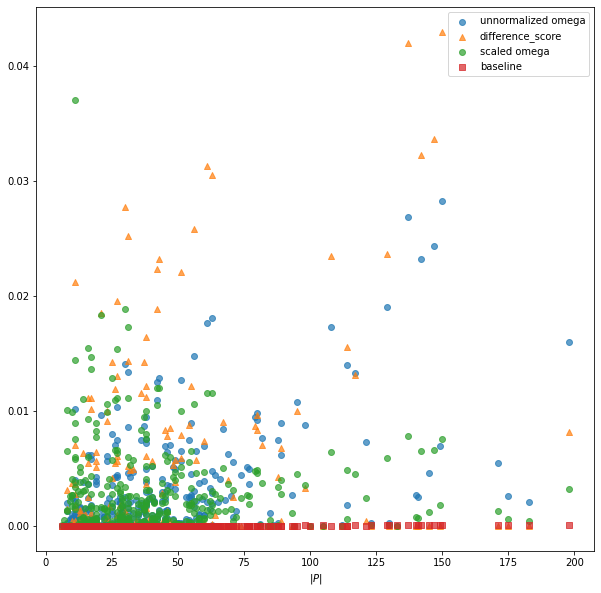

In [197]:
plt.figure(figsize=(10,10))

sample = 100
unnorm_omega = omega_dist.iloc[sample]
scaled_omega = (omegas.iloc[sample]/path_size[omegas.columns])
scaled_omega = scaled_omega/scaled_omega.sum()
y = diff_omega.iloc[sample]
bl = diff[drug].iloc[sample]

# y = np.maximum(omegas.iloc[sample]-bl, np.ones(len(bl))*1e-7)
# y = y/y.sum()

plt.scatter(path_size[unnorm_omega.index], unnorm_omega.values, alpha=0.7, label='unnormalized omega')
plt.scatter(path_size[y.index], y.values, alpha=0.7, label='difference_score', marker='^')
plt.scatter(path_size[scaled_omega.index], scaled_omega.values, alpha=0.7, label='scaled omega')
plt.scatter(path_size[bl.index], bl.values, alpha=0.7, label='baseline', marker='s')
# plt.ylabel(r'mean difference score across CLs')
plt.legend()
plt.xlabel(r'$|P|$')

WIKIPATH_EGF_EGFR_SIGNALING_PATHWAY_HOMO_SAPIENS_WP437         0.000144
WIKIPATH_REGULATION_OF_ACTIN_CYTOSKELETON_HOMO_SAPIENS_WP51    0.000141
WIKIPATH_INSULIN_SIGNALING_HOMO_SAPIENS_WP481                  0.000113
WIKIPATH_METAPATHWAY_BIOTRANSFORMATION_HOMO_SAPIENS_WP702      0.000108
Name: 910549, dtype: float64 WIKIPATH_EGF_EGFR_SIGNALING_PATHWAY_HOMO_SAPIENS_WP437         150
WIKIPATH_REGULATION_OF_ACTIN_CYTOSKELETON_HOMO_SAPIENS_WP51    137
WIKIPATH_INSULIN_SIGNALING_HOMO_SAPIENS_WP481                  147
WIKIPATH_METAPATHWAY_BIOTRANSFORMATION_HOMO_SAPIENS_WP702      142
dtype: int64


Text(0.5, 0, '$|P|$')

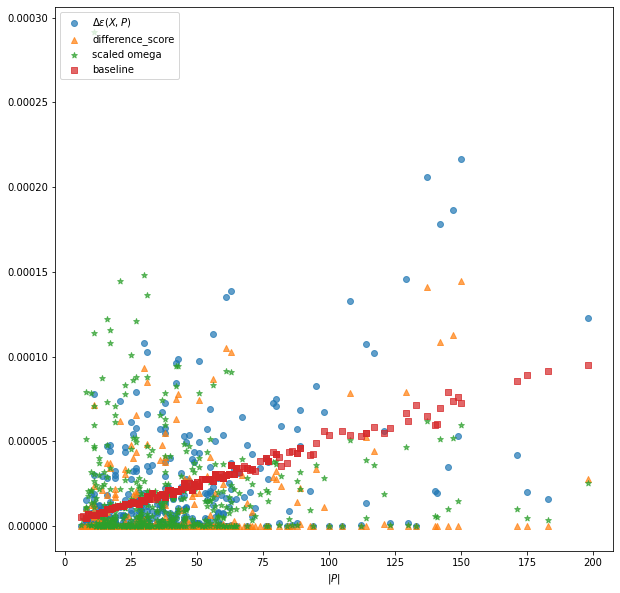

In [234]:
plt.figure(figsize=(10,10))

sample = 100
unnorm_omega = omegas.iloc[sample]
scaled_omega = (omegas.iloc[sample]/path_size[omegas.columns])*path_size.mean()

# y = diff_omega.iloc[sample]
bl = diff[drug].iloc[sample]

y = np.maximum(omegas.iloc[sample]-bl, np.ones(len(bl))*1e-7)

top = (omegas.iloc[sample]-bl).nlargest(4)
print(top, path_size[top.index])

plt.scatter(path_size[unnorm_omega.index], unnorm_omega.values, alpha=0.7, label=r'$\Delta \varepsilon(X,P)$')
plt.scatter(path_size[y.index], y.values, alpha=0.7, label='difference_score', marker='^')
plt.scatter(path_size[scaled_omega.index], scaled_omega.values, alpha=0.7, label='scaled omega', marker='*')
plt.scatter(path_size[bl.index], bl.values, alpha=0.7, label='baseline', marker='s')
# plt.ylabel(r'mean difference score across CLs')
plt.legend(loc='upper left')
plt.xlabel(r'$|P|$')

In [24]:
omega_dist.iloc[0].sum()

0.9999999

In [25]:
attr_gdsc.shape

(945, 439)

In [26]:
omega_dist.shape

(945, 439)

In [15]:
def get_pathway_rankings(folder):
    paths = {}
    for drug in drugs:
        x = pd.read_csv(root_dir + folder + '/' + drug + '/pathways.csv')
        paths[drug] = x
        
    return paths

In [16]:
rank_diff = get_pathway_rankings('CX_ens_enrichr3_diff')

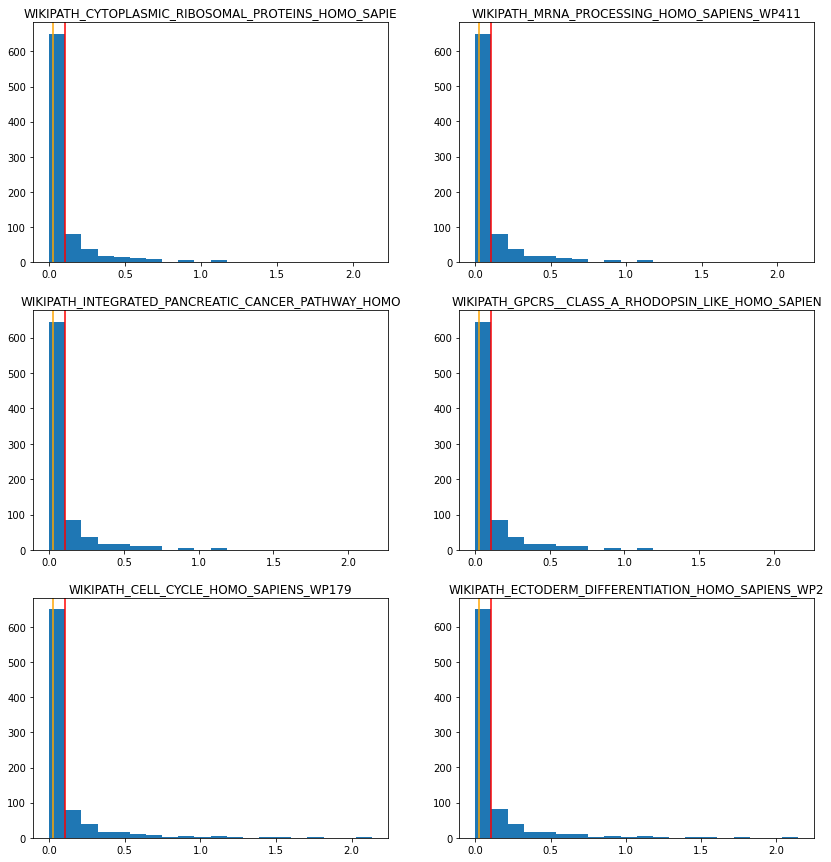

In [35]:
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

drug = 'bleomycin'
top6 = rank_diff[drug].loc[range(6)]['mean'].values
for i in range(6):
    ax = axes[i%3][i//3]
    ax.hist(diff[drug][top6[i]], bins=20)
    ax.set_title(top6[i][:50])
    ax.axvline(diff[drug][top6[i]].mean(), color='r', label='mean')
    ax.axvline(diff[drug][top6[i]].median(), color='orange', label='median')
plt.show()